# Apple stock price ARIMA/GARCH analysis

## Import library

In [135]:
import yfinance as yf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

In [104]:
# Define stock tickers
tickers = ["AAPL", "MSFT", "NVDA"]

# Define time range
start_date = "2020-01-01"
end_date = "2021-01-01"

# Download stock data
stock_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, ignore_tz=True)

# Extract only the 'Close' prices
data = stock_data["Close"]
data.columns = tickers

data

[*********************100%***********************]  3 of 3 completed


,AAPL,MSFT,NVDA
Date,,,
2020-01-02,72.716057,153.323303,5.972710
2020-01-03,72.009109,151.414093,5.877112
2020-01-06,72.582909,151.805481,5.901757
2020-01-07,72.241562,150.421341,5.973209
2020-01-08,73.403641,152.817352,5.984413
...,...,...,...
2020-12-24,128.905792,214.883316,12.960855
2020-12-28,133.516220,217.015289,12.867343
2020-12-29,131.738480,216.233856,12.910482


In [105]:
data.isnull().sum()

,0
AAPL,0
MSFT,0
NVDA,0


In [106]:
data.describe()

,AAPL,MSFT,NVDA
count,253.000000,253.000000,253.000000
mean,92.836982,185.298200,9.859559
std,21.444429,22.545255,2.927088
min,54.449890,129.621155,4.892426
25%,74.962799,166.596970,6.807797
50%,89.189926,193.802170,9.582217
75%,112.867676,204.421555,12.954285
max,133.516220,222.885468,14.520846


# Applce stock price visualization

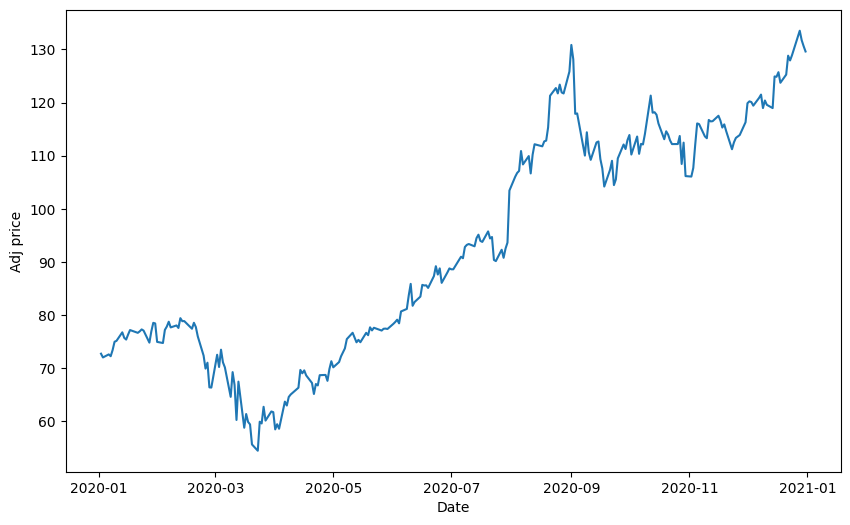

In [107]:
plt.figure(figsize=(10,6))
plt.plot(data.index,data['AAPL'])
plt.xlabel('Date')
plt.ylabel('Adj price')
plt.show()

In [127]:
data['Return'] = data['AAPL'].pct_change()
returns = data['Return'].dropna()
data.dropna(inplace=True)

## Augmented dickey fuller test

In [128]:
result = adfuller(data['Return'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The data satisfies stationarity. Differencing is not required.")
else:
    print("The data does not satisfy stationarity. Differencing is required.")

ADF Statistic: -4.948711018977989
p-value: 2.800916374714314e-05
The data satisfies stationarity. Differencing is not required.


In [129]:
# Suppress warning messages
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=Warning)

# Use first-order differenced data (stationary data)
returns = data['Return'].dropna()
data.dropna(inplace=True)

# Fit AR, MA, and ARMA models and store AIC/BIC results
aic_results = {}
bic_results = {}

# AR Model: ARIMA(p, 0, 0) for p = 1 to 4
for p in range(1, 5):
    try:
        model = ARIMA(returns, order=(p, 0, 0)).fit()
        aic_results[f'AR({p})'] = model.aic
        bic_results[f'AR({p})'] = model.bic
    except:
        aic_results[f'AR({p})'] = np.nan
        bic_results[f'AR({p})'] = np.nan

# MA Model: ARIMA(0, 0, q) for q = 1 to 4
for q in range(1, 5):
    try:
        model = ARIMA(returns, order=(0, 0, q)).fit()
        aic_results[f'MA({q})'] = model.aic
        bic_results[f'MA({q})'] = model.bic
    except:
        aic_results[f'MA({q})'] = np.nan
        bic_results[f'MA({q})'] = np.nan

# ARMA Model: ARIMA(p, 0, q) for p = 1 to 4, q = 1 to 4
for p in range(1, 5):
    for q in range(1, 5):
        try:
            model = ARIMA(returns, order=(p, 0, q)).fit()
            aic_results[f'ARMA({p},{q})'] = model.aic
            bic_results[f'ARMA({p},{q})'] = model.bic
        except:
            aic_results[f'ARMA({p},{q})'] = np.nan
            bic_results[f'ARMA({p},{q})'] = np.nan

# Select the best model based on AIC
best_model_aic = min(
    aic_results,
    key=lambda k: aic_results[k] if not pd.isna(aic_results[k]) else np.inf
)
print("Best model based on AIC:", best_model_aic)
print("AIC:", aic_results[best_model_aic])

# Select the best model based on BIC
best_model_bic = min(
    bic_results,
    key=lambda k: bic_results[k] if not pd.isna(bic_results[k]) else np.inf
)
print("Best model based on BIC:", best_model_bic)
print("BIC:", bic_results[best_model_bic])

# Display AIC and BIC values in a table (p = 0 to 4, q = 0 to 4)

def parse_model_key(key):
    """Extracts (p, q) values from model keys such as 'ARMA(2,3)'."""
    if key.startswith("ARMA"):
        match = re.match(r"ARMA\((\d+),(\d+)\)", key)
        if match:
            return int(match.group(1)), int(match.group(2))
    elif key.startswith("AR"):
        match = re.match(r"AR\((\d+)\)", key)
        if match:
            return int(match.group(1)), 0
    elif key.startswith("MA"):
        match = re.match(r"MA\((\d+)\)", key)
        if match:
            return 0, int(match.group(1))
    return None, None

# Prepare empty DataFrames for AIC and BIC (covering p = 0 to 4, q = 0 to 4)
p_values = range(5)
q_values = range(5)

aic_table = pd.DataFrame(index=p_values, columns=q_values, dtype=float)
bic_table = pd.DataFrame(index=p_values, columns=q_values, dtype=float)

# Fill AIC table
for key, val in aic_results.items():
    p, q = parse_model_key(key)
    if p is not None and q is not None:
        aic_table.loc[p, q] = val

# Fill BIC table
for key, val in bic_results.items():
    p, q = parse_model_key(key)
    if p is not None and q is not None:
        bic_table.loc[p, q] = val

aic_table.fillna(0, inplace=True)
bic_table.fillna(0, inplace=True)

# Display the AIC and BIC tables
print("\nAIC Table (rows = p, columns = q):")
print(aic_table)

print("\nBIC Table (rows = p, columns = q):")
print(bic_table)

Best model based on AIC: ARMA(2,2)
AIC: -1080.2207375952012
Best model based on BIC: AR(1)
BIC: -1059.843708957222

AIC Table (rows = p, columns = q):
             0            1            2            3            4
0     0.000000 -1068.301945 -1068.505849 -1066.935430 -1065.001188
1 -1070.420068 -1068.636837 -1066.764547 -1064.883052 -1063.036116
2 -1068.681224 -1066.551927 -1080.220738 -1062.969462 -1061.072908
3 -1066.751001 -1064.707528 -1062.731333 -1064.201513 -1057.094831
4 -1065.603161 -1073.350878 -1064.531355 -1068.091290 -1037.513572

BIC Table (rows = p, columns = q):
             0            1            2            3            4
0     0.000000 -1057.725586 -1054.404038 -1049.308165 -1043.848471
1 -1059.843709 -1054.535025 -1049.137282 -1043.730335 -1038.357945
2 -1054.579412 -1048.924662 -1059.068020 -1038.291291 -1032.869285
3 -1049.123736 -1043.554810 -1038.053162 -1035.997889 -1025.365755
4 -1044.450444 -1048.672707 -1036.327731 -1036.362214 -1002.259043


## AR(1)

In [131]:
model = ARIMA(data['Return'],
                order=(1,0,0),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  251
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 535.619
Date:                Tue, 11 Mar 2025   AIC                          -1065.238
Time:                        20:38:44   BIC                          -1054.674
Sample:                             0   HQIC                         -1060.986
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.942      0.052   -2.58e-05       0.006
ar.L1         -0.2666      0.043     -6.207      0.000      -0.351      -0.182
sigma2         0.0008   4.69e-05     17.190      0.0

## ARMA(2,2)

In [132]:
model = ARIMA(data['Return'],
                order=(2,0,2),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  251
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 537.195
Date:                Tue, 11 Mar 2025   AIC                          -1062.389
Time:                        20:39:33   BIC                          -1041.309
Sample:                             0   HQIC                         -1053.903
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.710      0.087      -0.000       0.006
ar.L1         -1.7442      0.061    -28.660      0.000      -1.864      -1.625
ar.L2         -0.8949      0.060    -15.014      0.0

## Autocorrelation and Partial Autocorrelation Plot

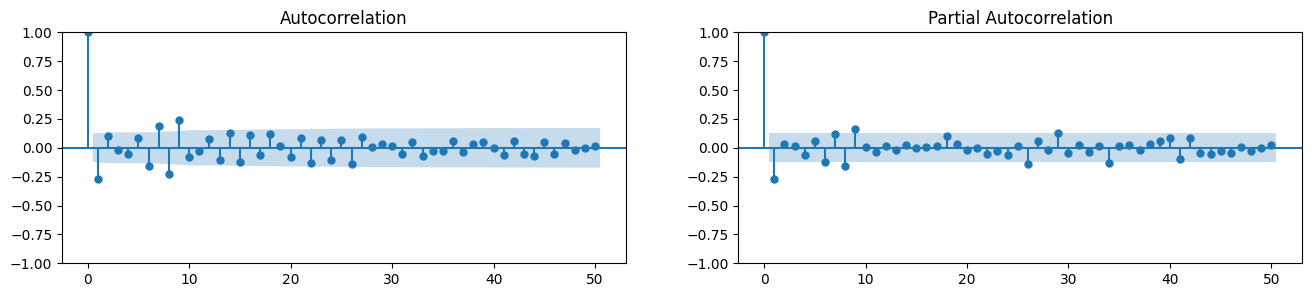

In [133]:
# Draw Autocorrelation and Partial Autocorrelation Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(data['Return'], lags=50, ax=axes[0])
plot_pacf(data['Return'], lags=50, ax=axes[1])

# Show the figure only once
plt.show()

In the ARMA results, no autocorrelation was found in the residuals. However, the Heteroskedasticity (H) value was 0.48, and the Jarque-Bera (JB) test result was 88.81, indicating that the residuals do not follow a normal distribution and do not satisfy homoscedasticity. Therefore, to account for the time-varying volatility, the GARCH model was applied.

The AR(1) model assumes that the time series depends linearly on its previous value, meaning it predicts the conditional mean.

Additionally, the basic AR(1) model assumes homoskedasticity, meaning the variance of the noise term remains constant over time:

However, in real-world data—especially in financial and economic time series—variance is often not constant. For example:

Financial markets: Periods of high and low volatility (e.g., financial crises vs. stable periods).
Exchange rates and interest rates: Large fluctuations in certain periods, followed by reduced volatility.
While AR(1) models are effective for predicting the conditional mean, they struggle when volatility varies over time. To address this, ARCH/GARCH models are used to capture time-varying volatility patterns.









# GARCH

Iteration:      5,   Func. Count:     27,   Neg. LLF: -561.3312693575413
Iteration:     10,   Func. Count:     49,   Neg. LLF: -563.1683456101773
Optimization terminated successfully    (Exit mode 0)
            Current function value: -563.1683456101717
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                563.168
Distribution:                  Normal   AIC:                          -1120.34
Method:            Maximum Likelihood   BIC:                          -1109.76
                                        No. Observations:                  251
Date:                Tue, Mar 11 2025   Df Residuals:                      251
Time:       

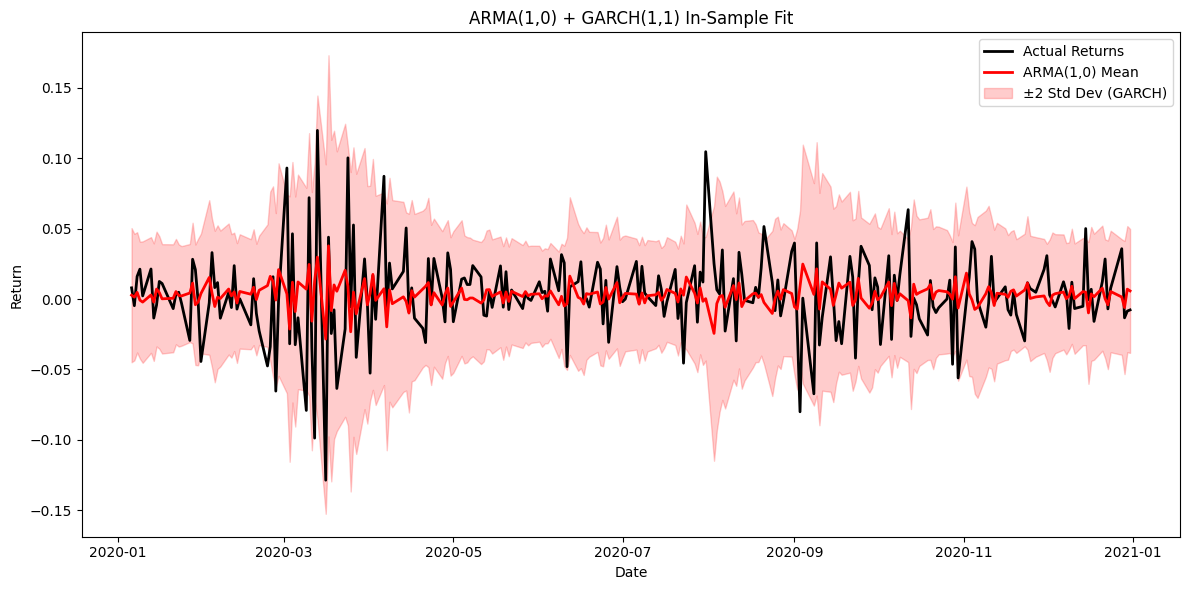

In [145]:
# Fit ARMA(1,0) on the returns (mean equation)
arma_model = ARIMA(returns, order=(1, 0, 0)).fit()
mu = arma_model.fittedvalues  # ARMA in-sample fitted mean
residuals = arma_model.resid  # ARMA residuals

# Fit GARCH(1,1) on the ARMA residuals (variance equation)
garch_model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
garch_fitted = garch_model.fit(update_freq=5)
print(garch_fitted.summary())

# GARCH conditional volatility (standard deviation)
sigma = garch_fitted.conditional_volatility

# Combine ARMA mean + GARCH volatility
# The best "fitted value" for returns is mu_t (ARMA's mean).
# GARCH gives us sigma_t, which we can use to form a confidence band.
upper = mu + 2 * sigma
lower = mu - 2 * sigma

# Plot everything on one figure
plt.figure(figsize=(12, 6))

# Actual returns
plt.plot(returns.index, returns, label="Actual Returns", color="black", linewidth=2)

# ARMA(1,1)-GARCH(1,1) fitted mean
plt.plot(mu.index, mu, label="ARMA(1,0) Mean", color="red", linewidth=2)

# Confidence band (+/- 2 std dev from GARCH)
plt.fill_between(mu.index, lower, upper, color="red", alpha=0.2, label="±2 Std Dev (GARCH)")

plt.title("ARMA(1,0) + GARCH(1,1) In-Sample Fit")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

#EGARCH

Iteration:      5,   Func. Count:     31,   Neg. LLF: -563.235620231344
Optimization terminated successfully    (Exit mode 0)
            Current function value: -563.267716763067
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                     EGARCH   Log-Likelihood:                563.268
Distribution:                  Normal   AIC:                          -1120.54
Method:            Maximum Likelihood   BIC:                          -1109.96
                                        No. Observations:                  251
Date:                Tue, Mar 11 2025   Df Residuals:                      251
Time:                        21:20:20   Df Model:                            0
          

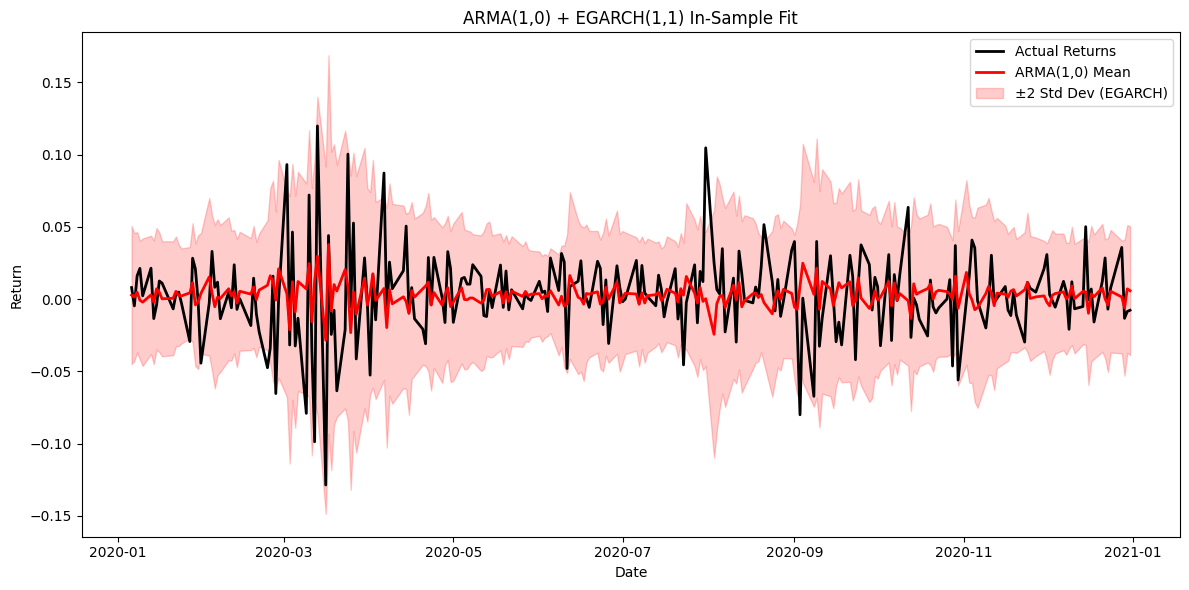

In [146]:
# Fit ARMA(1,0) on the returns (mean equation)
arma_model = ARIMA(returns, order=(1, 0, 0)).fit()
mu = arma_model.fittedvalues  # ARMA in-sample fitted mean
residuals = arma_model.resid  # ARMA residuals

# Fit GARCH(1,1) on the ARMA residuals (variance equation)
egarch_model = arch_model(residuals, mean='Zero', vol='EGARCH', p=1, q=1, dist='normal')
egarch_fitted = egarch_model.fit(update_freq=5)
print(egarch_fitted.summary())

# GARCH conditional volatility (standard deviation)
sigma = egarch_fitted.conditional_volatility

# Combine ARMA mean + EGARCH volatility
# The best "fitted value" for returns is mu_t (ARMA's mean).
# EGARCH gives us sigma_t, which we can use to form a confidence band.
upper = mu + 2 * sigma
lower = mu - 2 * sigma

# Plot everything on one figure
plt.figure(figsize=(12, 6))

# Actual returns
plt.plot(returns.index, returns, label="Actual Returns", color="black", linewidth=2)

# ARMA(1,1)-EGARCH(1,1) fitted mean
plt.plot(mu.index, mu, label="ARMA(1,0) Mean", color="red", linewidth=2)

# Confidence band (+/- 2 std dev from EGARCH)
plt.fill_between(mu.index, lower, upper, color="red", alpha=0.2, label="±2 Std Dev (EGARCH)")

plt.title("ARMA(1,0) + EGARCH(1,1) In-Sample Fit")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

In the GARCH/EGARCH model, omega represents the long-term unconditional variance, alpha captures the impact of recent shocks on current volatility through the squared error term, and beta reflects the persistence of past volatility by incorporating the previous period's predicted variance. The statistical significance of these three parameters indicates that both recent shocks and past volatility significantly influence current volatility, confirming that the model effectively captures the time-varying nature of volatility in the data. The squared error term represents the past period's shock, meaning that if recent volatility is high, future volatility is also likely to remain high. The predicted variance from the previous period shows that past volatility affects current volatility. The baseline variance level is represented by alpha zero. Overall, the GARCH model predicts whether future volatility will be high or low, determining how much dispersion is expected in the data.

Both models exhibit similar levels of log-likelihood, AIC, and BIC metrics, indicating a well-fitted mean model. In the EGARCH model, omega is -0.5311, alpha is 0.3196, and beta is 0.9245. Since EGARCH models the logarithm of variance, a negative omega does not necessarily indicate an issue. On the other hand, in the GARCH model, omega is estimated at 5.1975e-05, alpha at 0.1480, and beta at 0.7904, with the parameter signs and magnitudes aligning with expected values. While both models yield statistically significant results, further residual diagnostics and predictive performance evaluation are necessary to comprehensively determine which model better captures the volatility clustering in the data.